In [1]:
!pip install tensorflow numpy opencv-python scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive') # Add the mountpoint here

Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-5-46fcaf3d1238>:15: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


Enter similarity threshold (0 to 1): 0.85
Enter the path to the new icon: /content/drive/MyDrive/M.TECH (AI)/SEM IV/ADL/University/Siamese/Unmute.png
Enter the path to the directory containing existing icons: /content/drive/MyDrive/M.TECH (AI)/SEM IV/ADL/University/Siamese/iconSet
Matches ≥ 85%:
Unmute.png - 100.00%
Mute.png - 88.07%


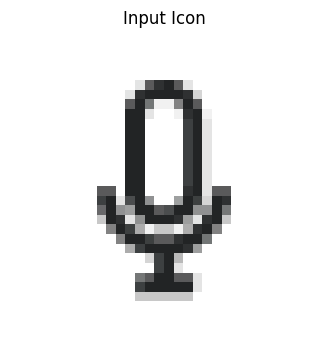

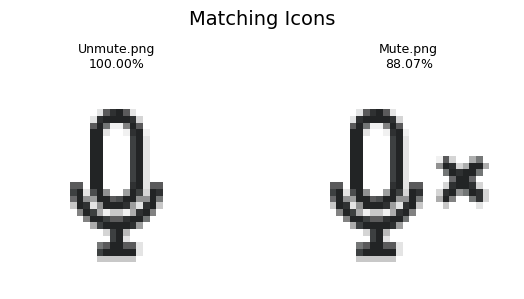

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load MobileNetV2 model without top layer for feature extraction
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

# Preprocess an image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not load image from {image_path}. Skipping.")
        return None
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_input(np.expand_dims(img.astype(np.float32), axis=0))
    return img

# Extract feature vector
def get_feature_vector(image_path):
    img = preprocess_image(image_path)
    if img is None:
        return None
    feature = model.predict(img, verbose=0)
    return feature.flatten()

# Compare new icon with dataset
def compare_icons(new_icon_path, existing_icons_dir, threshold=0.80):
    new_icon_vec = get_feature_vector(new_icon_path)
    if new_icon_vec is None:
        print(f"Error: Could not process the new icon at {new_icon_path}.")
        return []

    match_results = []
    for filename in os.listdir(existing_icons_dir):
        if filename.lower().endswith('.png'):
            path = os.path.join(existing_icons_dir, filename)
            existing_vec = get_feature_vector(path)
            if existing_vec is not None:
                similarity = cosine_similarity([new_icon_vec], [existing_vec])[0][0]
                if similarity >= threshold:
                    match_results.append((filename, similarity * 100))  # Store similarity as percentage

    # Sort matches by similarity percentage in descending order
    match_results.sort(key=lambda x: x[1], reverse=True)

    return match_results

# Display the input icon and matched icons
def display_input_and_matched_icons(input_icon_path, matches, icon_dir, title="Matching Icons"):
    input_img = cv2.imread(input_icon_path, cv2.IMREAD_UNCHANGED)
    if input_img is None:
        print(f"Error: Could not load input image from {input_icon_path}")
        return

    if input_img.shape[-1] == 4:
        alpha = input_img[:, :, 3] / 255.0
        input_rgb = cv2.cvtColor(input_img[:, :, :3], cv2.COLOR_BGR2RGB)
        white_bg = np.ones_like(input_rgb, dtype=np.uint8) * 255
        input_rgb = (alpha[:, :, None] * input_rgb + (1 - alpha[:, :, None]) * white_bg).astype(np.uint8)
    else:
        input_rgb = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(4, 4))
    plt.imshow(input_rgb)
    plt.title("Input Icon", fontsize=12)
    plt.axis('off')
    plt.show()

    if not matches:
        print("No matches above threshold.")
        return

    cols = min(5, len(matches))
    rows = (len(matches) + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 3))

    for idx, (filename, score) in enumerate(matches):
        path = os.path.join(icon_dir, filename)
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

        if img is None:
            print(f"Warning: Could not load image for display from {path}. Skipping.")
            continue

        if img.shape[-1] == 4:
            alpha = img[:, :, 3] / 255.0
            img_rgb = cv2.cvtColor(img[:, :, :3], cv2.COLOR_BGR2RGB)
            white_bg = np.ones_like(img_rgb, dtype=np.uint8) * 255
            img_rgb = (alpha[:, :, None] * img_rgb + (1 - alpha[:, :, None]) * white_bg).astype(np.uint8)
        else:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(rows, cols, idx + 1)
        plt.imshow(img_rgb)
        plt.title(f"{filename}\n{score:.2f}%", fontsize=9)
        plt.axis('off')

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Get threshold from user
while True:
    try:
        user_threshold = float(input("Enter similarity threshold (0 to 1): "))
        if 0 <= user_threshold <= 1:
            break
        else:
            print("Please enter a value between 0 and 1.")
    except ValueError:
        print("Invalid input. Please enter a numeric value.")

# Get paths from the user
new_icon_path = input("Enter the path to the new icon: ")
existing_icons_dir = input("Enter the path to the directory containing existing icons: ")

matches = compare_icons(new_icon_path, existing_icons_dir, threshold=user_threshold)

# Print results
print(f"Matches ≥ {user_threshold * 100:.0f}%:")
for filename, score in matches:
    print(f"{filename} - {score:.2f}%")

# Display matched icons
display_input_and_matched_icons(new_icon_path, matches, existing_icons_dir, title="Matching Icons")
